In [ ]:
import imagehash
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os.path

# Анализ данных

Проанализируем метаданные в обучающем наборе

In [ ]:
petfinder_train_df = pd.read_csv("train.csv")
petfinder_train_df.head()

,Id,Subject Focus,Eyes,Face,Near,...,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,...,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,...,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,...,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,...,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,...,0,0,0,0,72


In [ ]:
petfinder_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


Проанализируем распределение оценок привлекательности

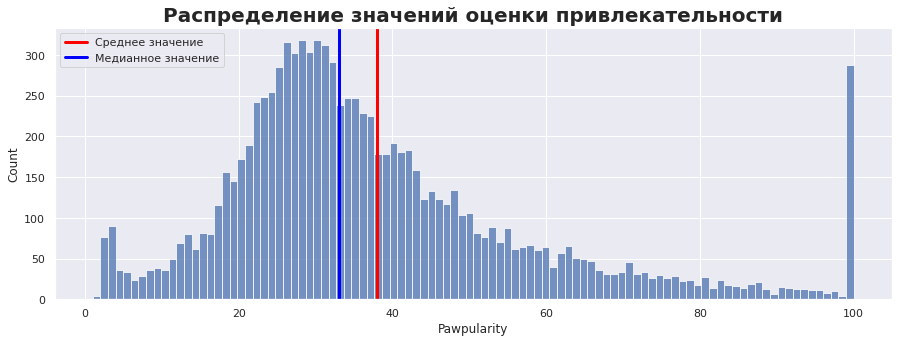

In [ ]:
#Lets see a the distribution of Pawpularity Scores
sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure()
pawpularity_mean = round(petfinder_train_df['Pawpularity'].mean(), 2)
pawpularity_median = round(petfinder_train_df['Pawpularity'].median(), 2)
sns.histplot(data=petfinder_train_df, x='Pawpularity', bins=100)
plt.axvline(pawpularity_mean, c='red', ls='-', lw=3, label='Среднее значение')
plt.axvline(pawpularity_median,c='blue',ls='-',lw=3, label='Медианное значение')
plt.title(f'Распределение значений оценки привлекательности', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

In [ ]:
petfinder_train_df[["Pawpularity"]].describe()

,Pawpularity
count,9912.000000
mean,38.039044
std,20.591990
min,1.000000
25%,25.000000
50%,33.000000
75%,46.000000
max,100.000000


Из гистрограммы распределений оценки привлекательности можно сделать следующие выводы:

- Более 75% фотографий в наборе не привлекательны для потенциальных хозяев питомцев;
- Более 250 фотографий имеют оценку 100 (необходимо разобраться что особенного в этих фотографиях, являются ли они выбросами, нужно ли использовать эти данные в модели или нет).

Анализировать метаданные по средней, медиане и квартилям не обязательно, так как там только бинарные значения

### Распределение оценки привлекательности по метаданным

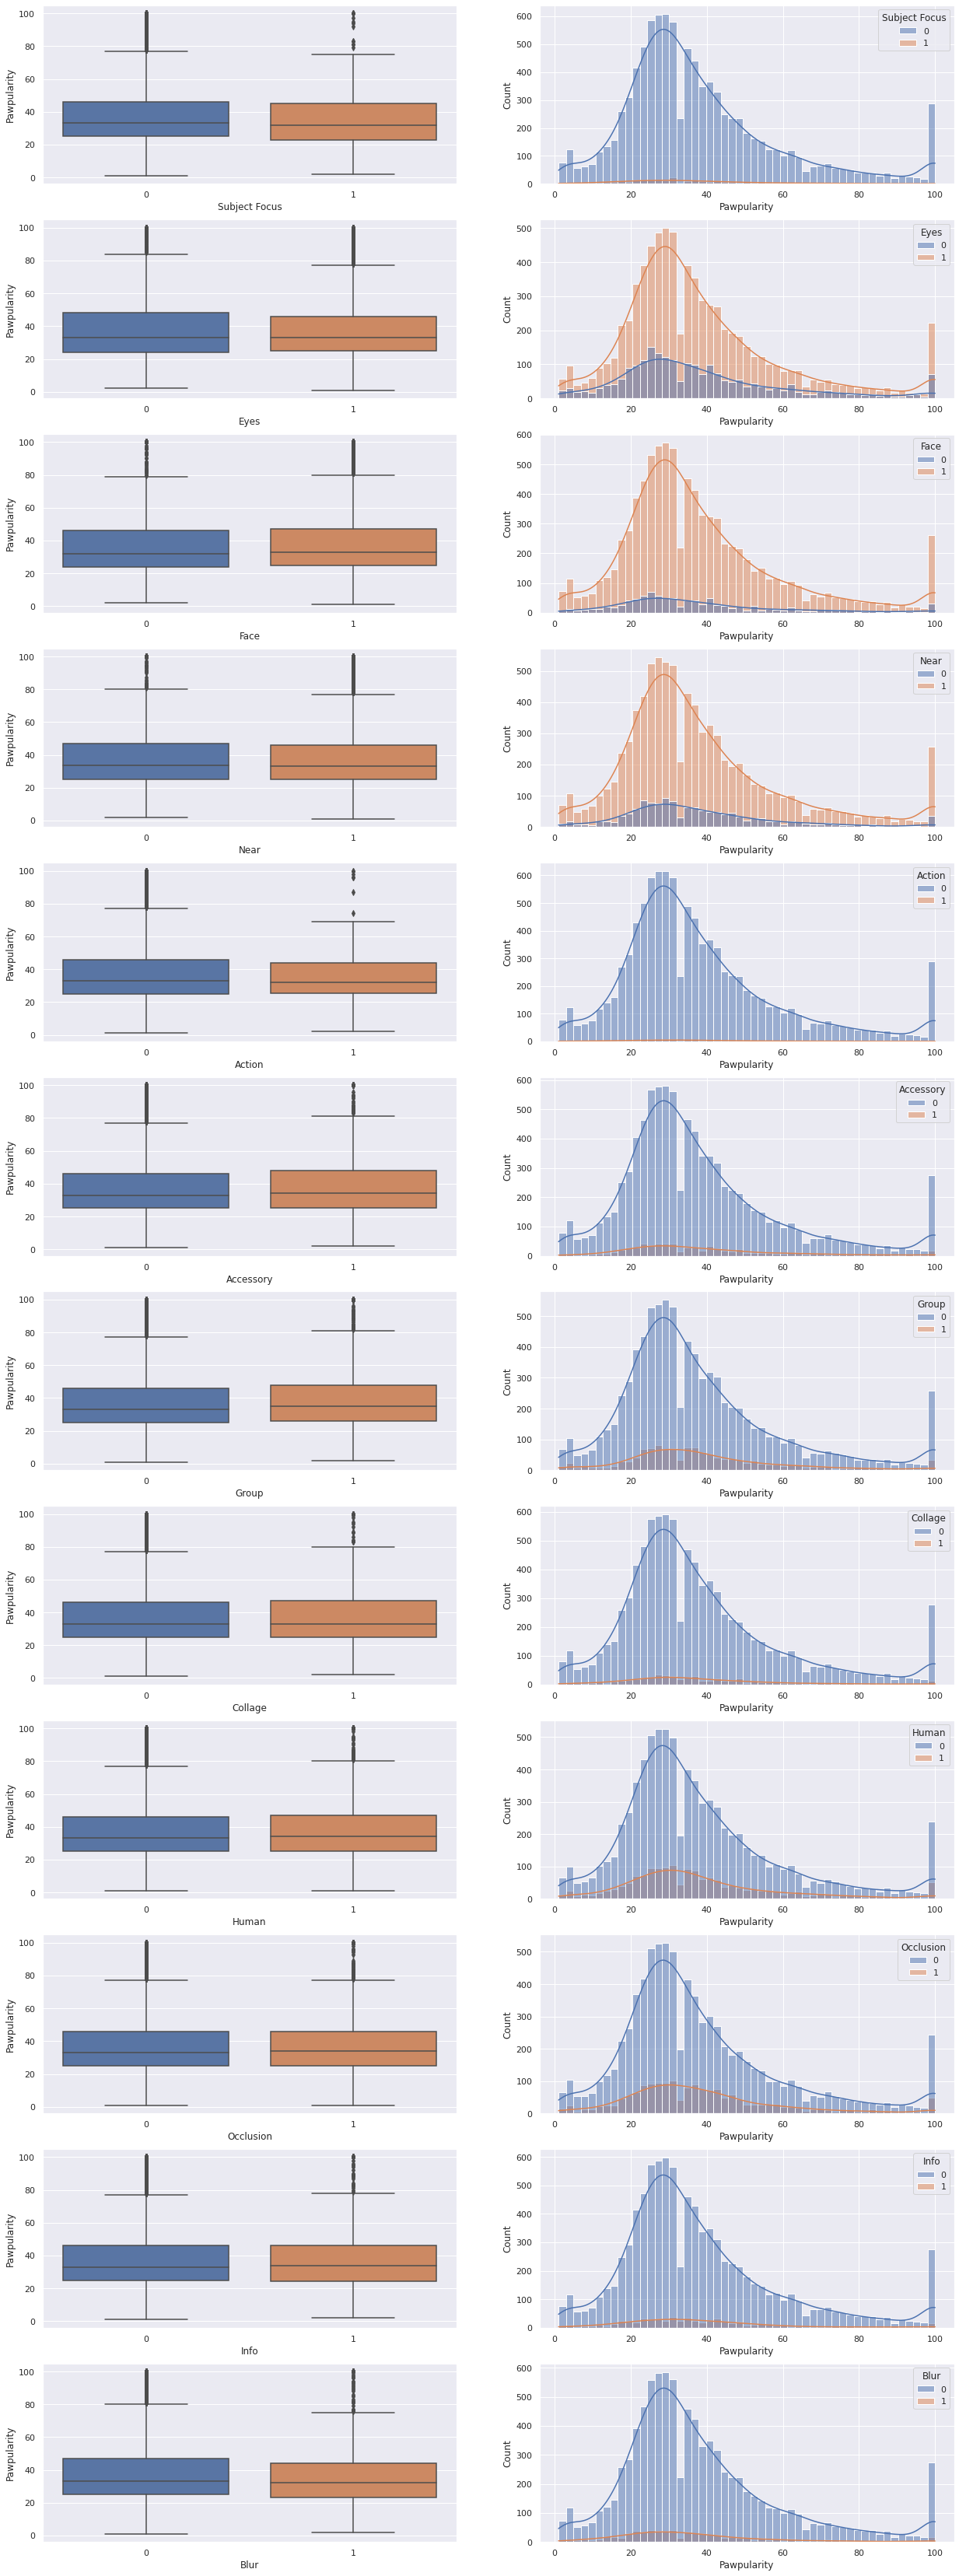

In [ ]:
# Распределение оценки привлекательности для Eyes

fig, ax = plt.subplots(12,2, figsize=(21, 60))
meta = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

for idx, (axes_line, meta_name) in enumerate(zip(ax, meta)):
    sns.boxplot(data=petfinder_train_df, x=meta_name, 
                y='Pawpularity', ax=axes_line[0])
    sns.histplot(petfinder_train_df, x="Pawpularity", hue=meta_name, kde=True, ax=axes_line[1])
fig.show()

Из полученных распределений видно, что метаданные практически не оказывают влияния на оценку привлекательности. В рамках каждого типа метаданных распределения разных значений практически совпадают. При этом наблюдается дисбаланс, значения 1 в рамках типов значительно превышают значения 0. Если строить модель только по метаданным, то хороших результатов добиться не получится. Поэтому основой для обучения модели будут непосредственно изображения питомцев.

Аналогичный вывод можно сделать по таблице корреляции, ни один из типов метаданных не имеет корреляции с оценкой привлекательности.

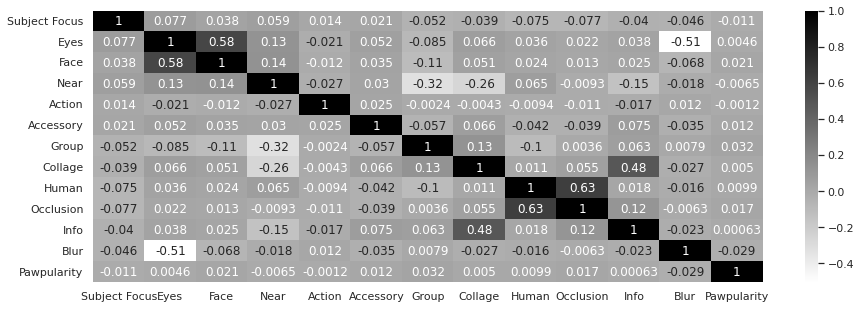

In [ ]:
meta_corr = petfinder_train_df[meta+["Pawpularity"]].corr(method='spearman')
sns.heatmap(meta_corr, cmap='gist_yarg', annot=True)
plt.show()

### Анализ изображений

In [ ]:
def print_pet_images(petfinder_train_df, pawpularity=None, img_count=12, 
                     photo_dir='train'):
    """ Печать фотографий питомцев

    Параметры
    ---------
    petfinder_train_df : pd.DataFrame
      Датасет
    pawpularity : int
      Фильтр привлекательности, если None, то фильтрации не будет
    img_count : int
      Кол-во фото для печати
    photo_dir : str
      Путь к папке с фото
    """

    assert img_count > 0
    if photo_dir[-1] != os.path.sep:
        photo_dir += os.path.sep

    if pawpularity is not None:
        dataframe = petfinder_train_df[petfinder_train_df.Pawpularity == pawpularity]
    else:
        dataframe = petfinder_train_df

    if len(dataframe) == 0:
        return

    images_idx = np.random.permutation(len(dataframe))[:img_count]

    plot_cols = 4
    plot_rows = img_count // plot_cols
    figsize = (12, 4*plot_rows)

    fig, axes = plt.subplots(plot_rows, plot_cols, figsize=figsize)

    for idx, ax in zip(images_idx, axes.flatten()):
        pawpularity = dataframe.iloc[idx].Pawpularity
        photo_path = photo_dir + dataframe.iloc[idx].Id + '.jpg'
        image = Image.open(photo_path)
        ax.set_title(f"Pawpularity: {pawpularity}")
        ax.axis('off')
        ax.imshow(image)
    plt.show()

### Фото с оценкой привлекательности 2

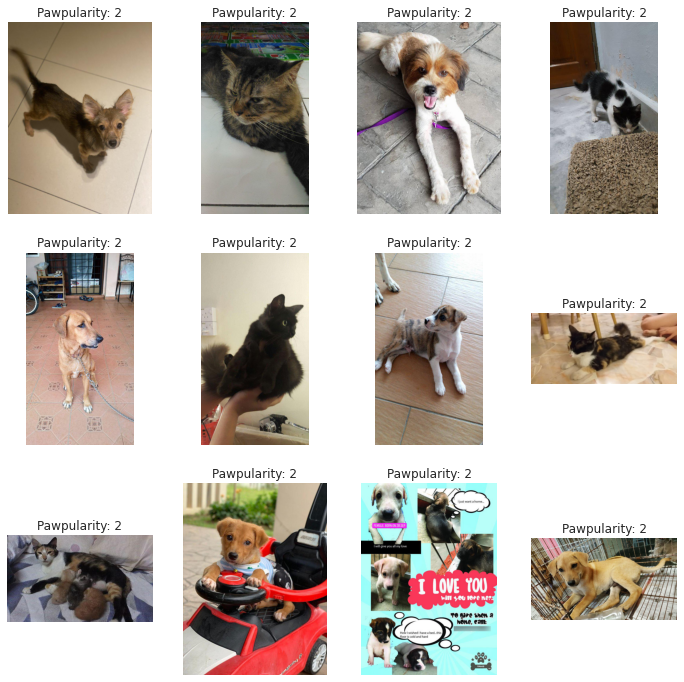

In [ ]:
print_pet_images(petfinder_train_df, pawpularity=2, img_count=12)

### Фото с оценкой привлекательности 25

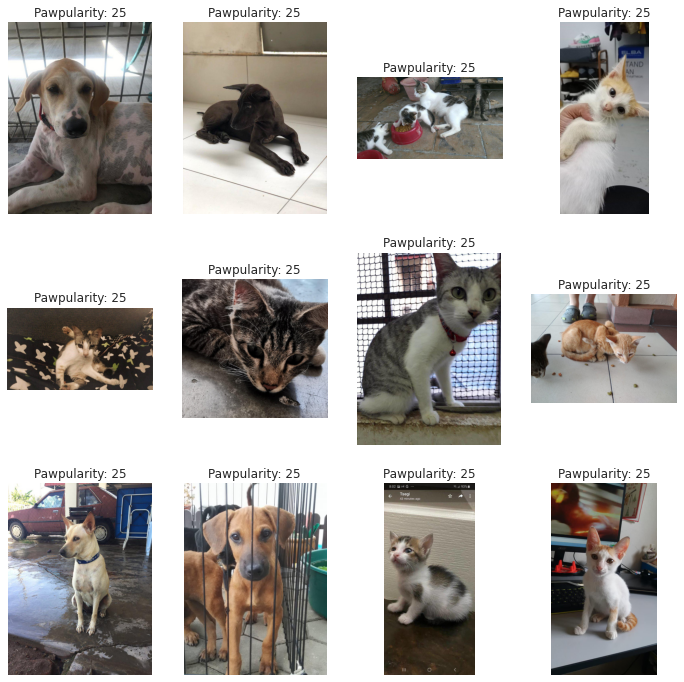

In [ ]:
print_pet_images(petfinder_train_df, pawpularity=25, img_count=12)

### Фото с оценкой привлекательности 50

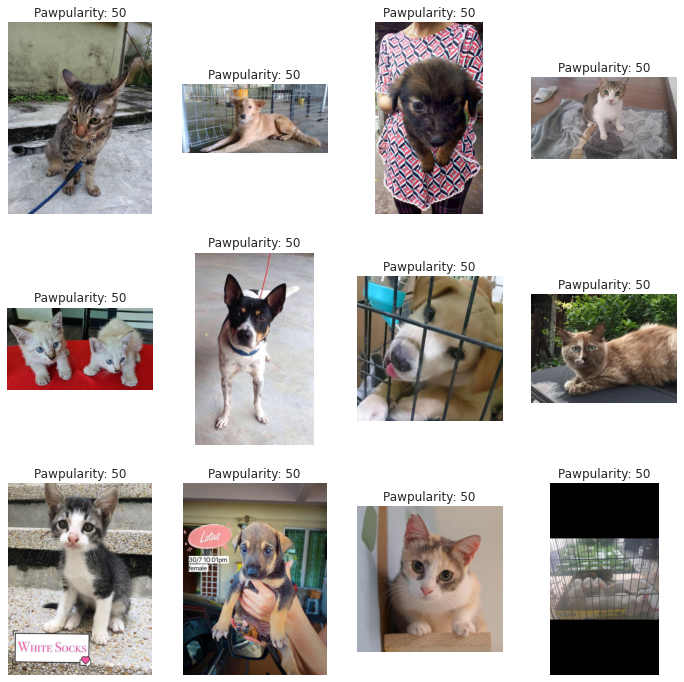

In [ ]:
print_pet_images(petfinder_train_df, pawpularity=50, img_count=12)

### Фото с оценкой привлекательности 75

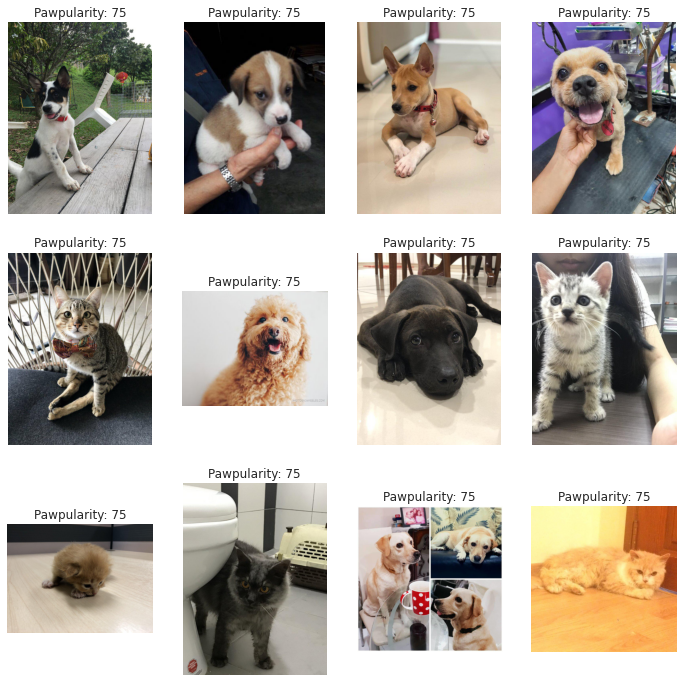

In [ ]:
print_pet_images(petfinder_train_df, pawpularity=75, img_count=12)

### Фото с оценкой привлекательности 100

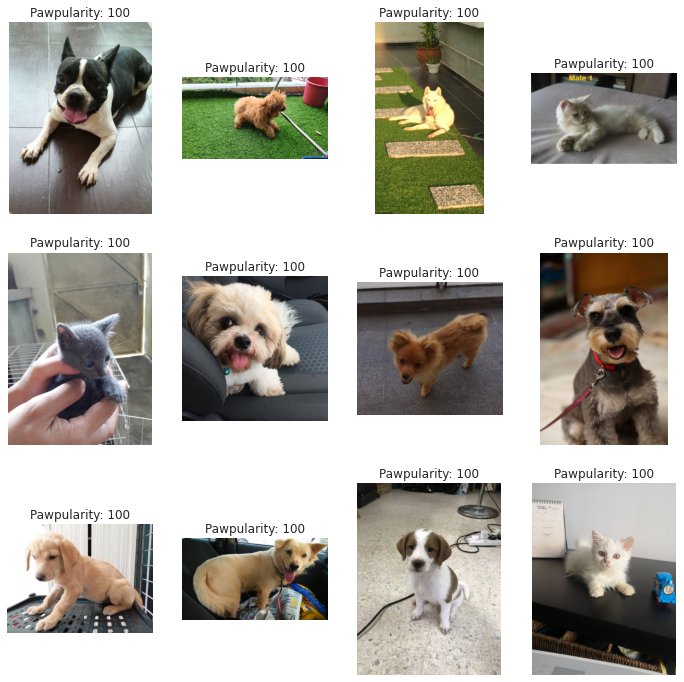

In [ ]:
print_pet_images(petfinder_train_df, pawpularity=100, img_count=12)

Из полученных изображений сложно дать категоричный вывод почему одни фотографии популярные, а другие нет. Но можно заметить тенденцию, что фотографии более привлекательны, если питомец улыбается, имеет опрятный вид, имеет необычный аксессуар в виде бабочки на шее. Так же высокие оценки могут получать изображения с комичными ситуациями (строгий кот возле унитаза, забавное оптическое искажение мордочки собаки).

Так же сложно назвать причины почему у более 250 фото (выброс) стоит оценка 100, фотографии в целом интересные и позитивные, но фото с оценками немного ниже в целом похожи. Поэтому данные фотографии можно удалить из обучающей выборки.